# Social network analysis
## Step 1: Getting SN from VK API

In [370]:
import vk
from ratelimit import limits, sleep_and_retry
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy.spatial as spt
import pandas

In [ ]:
token = <token here>
app_id = 7655617
user_id = 93812385

In [ ]:
# init vk api
vkapi = vk.API(access_token=token, api_version=5.52)

In [ ]:
# get friends with fields
DEFAULT_FIELDS = "sex,city,education"

friends = vkapi.friends.get(fields=DEFAULT_FIELDS, lang="en")["items"]

In [129]:
REMOVED_PAGE_ERROR = 18

@sleep_and_retry
@limits(calls=2, period=1)
def get_friends(uid):
    try:
        friends_list = vkapi.friends.get(user_id=uid, fields=DEFAULT_FIELDS, lang='en')['items']
        return {item['id']:item for item in friends_list}
    except vk.VkAPIMethodError as err:
        error = err.error
        if error['error_code'] == REMOVED_PAGE_ERROR:
            return None
        else:
            raise err

In [130]:
# getting friends info from VK API
friends_info = get_friends(user_id)
print('Number of friends: %d' % len(friends_info))

Number of friends: 254


In [84]:
graph = {}
friends_ids = friends_info.keys()

# proccessing friends connections
for friend_id in tqdm(friends_ids):
    friends_info = get_friends(friend_id)
    if friends is not None:
        graph[friend_id] = get_friends(friend_id)

100%|██████████| 254/254 [04:11<00:00,  1.01it/s]


## Step2: Forming network and analysis

In [360]:
# -*- coding: utf-8 -*-

# forming network
g = networkx.Graph(directed=False)

def get_node_name(uid):
    friend_info = friends_info[uid]
    node_name = '%s %s' % (friend_info['first_name'], friend_info['last_name'])
    return node_name

universites_dict = dict()
faculties_dict = dict()

for uid in graph:
    friend_info = friends_info[uid]
    node_name = get_node_name(uid)
    male = 'man' if friend_info['sex'] == 2 else 'woman'
    city = friend_info['city']['title'] if 'city' in friend_info else 'undefined'
    faculty = friend_info['faculty'] if 'faculty' in friend_info else 'undefined'
    university = friend_info['university'] if 'university' in friend_info else 'undefined'
    if faculty != 'undefined':
        faculties_dict[faculty] = friend_info["faculty_name"]
    if university != "undefined":
        universites_dict[university] = friend_info["university_name"]
    uid = friend_info['id']
    info = dict(gender=male, city=city, faculty=faculty, university=university, uid=uid)
    g.add_node(node_name, **info)
    
    for friend_id in graph[uid]:
        if friend_id != uid and friend_id in friends_ids and uid in friends_ids:
            node1 = get_node_name(uid)
            node2 = get_node_name(friend_id)
            g.add_edge(node1, node2)

In [369]:
nx.write_gml(g, "./data/netrwork.gml")

In [250]:
print('Size: %d' % len(g.edges()))
print('Order: %d' % len(g.nodes()))

Size: 3425
Order: 252


In [171]:
degres = list(g.degree())
max_degree = max(degres, key=lambda x: x[1])

print('Max degree info node: ', max_degree)

interval = 4
degres_distribution_Y = np.zeros(max_degree[1] // interval + 1)
degres_distribution_X = np.arange(0, max_degree[1], interval, dtype=int)
for degree_info in degres:
    k = degree_info[1] // interval
    degres_distribution_Y[k] += 1

Max degree info node:  ('Pavel Mazhnik', 159)


Text(0.5, 0.98, 'Degree distribution')

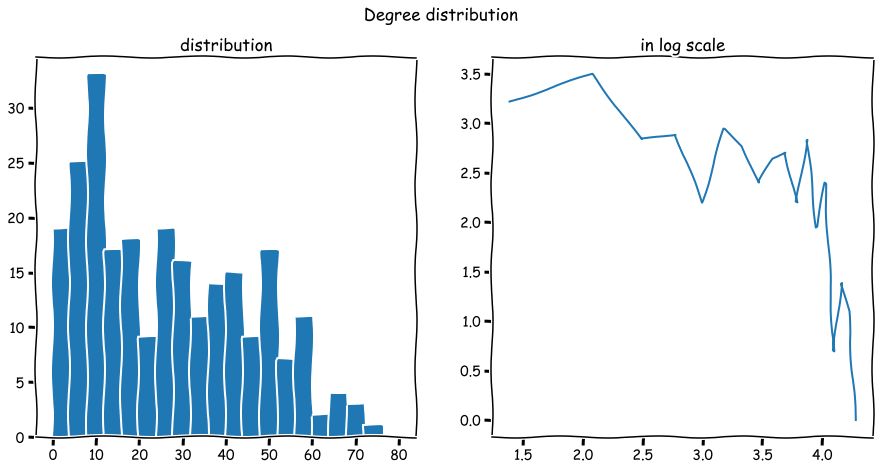

In [227]:
# plot degree distribution to check power law
plt.xkcd()

boundary = 20
x = degres_distribution_X[:boundary]
y = degres_distribution_Y[:boundary]
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].bar(x, y, width=interval, align='edge')
axs[0].set_title('distribution')
axs[1].plot(np.log(x), np.log(y))
axs[1].set_title('in log scale')
fig.suptitle('Degree distribution')

In [225]:
largest_cc = max(nx.connected_components(g), key=len)
largest_cc_graph = g.subgraph(largest_cc).copy()
diameter = nx.diameter(largest_cc_graph)
print('Diameter of largest cc: %d' % diametr)

avg_path = nx.average_shortest_path_length(largest_cc_graph)
print('Avg path: %.2f' % avg_path)

clustering_coefficient = nx.average_clustering(g)
print('Clustering coefficient %.2f' % clustering_coefficient)

Diameter of largest cc: 5
Avg path: 2.28
Clustering coefficient 0.57


## Step3: Structural analysis

In [229]:
A = nx.to_numpy_matrix(g)
A = np.asarray(A)

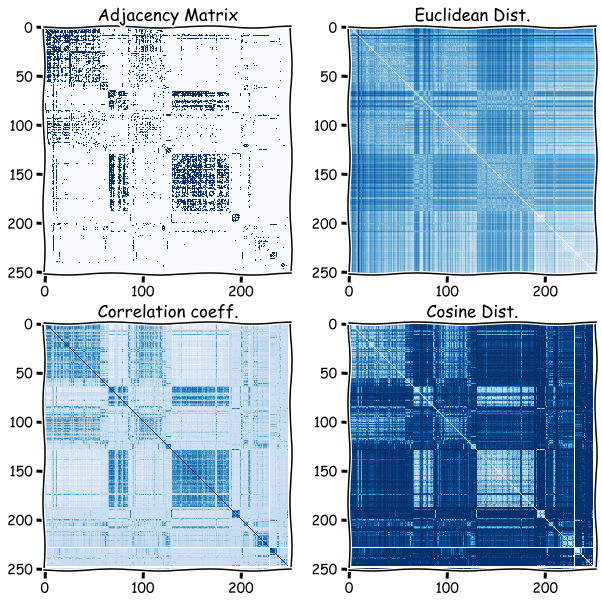

In [267]:
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Blues', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].set_title('Cosine Dist.')
    ax[1, 1].imshow(D, cmap = 'Blues', interpolation = 'None')

In [367]:
# calculation assortative mixing coefficients
attributes = ["gender", "city", "faculty", "university"]
assortivity_dict = {attribute:nx.attribute_assortativity_coefficient(g, attribute=attribute) for attribute in attributes}
assortivity_dict["degree"] = nx.degree_assortativity_coefficient(g)
attributes.append("degree")

<BarContainer object of 5 artists>

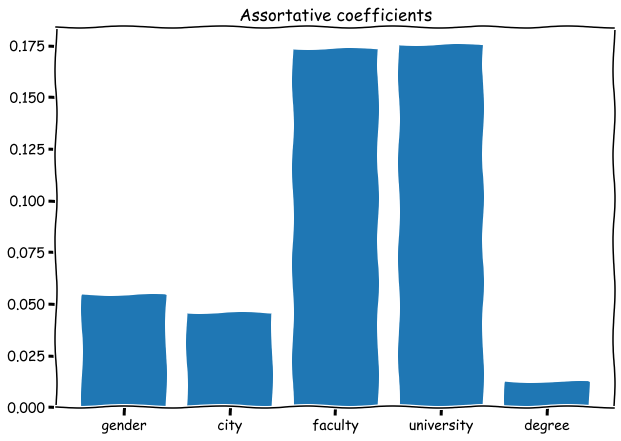

In [434]:
x = np.arange(len(attributes))
y = assortivity_dict.values()

plt.figure(figsize=(10, 7))
plt.title("Assortative coefficients")
plt.xticks(x, tuple(attributes))
plt.bar(x, y)

In [289]:
# build different random graph models for

edges_number = len(g.edges())
nodes_number = len(g.nodes())

n = nodes_number
m = 15
ba_graph = nx.barabasi_albert_graph(n=n, m=m)

gnm_random_graph = nx.gnm_random_graph(nodes_number, edges_number)

k = 2 * edges_number // nodes_number
p = 0.5
ws_graph = nx.watts_strogatz_graph(n=nodes_number, k=k, p=p)

In [309]:
def print_params(model_name, graph):
    print('%s model random graph params' % model_name)
    print('Size: %d\nOrder: %d\nDensity: %.3f\nClust. coef: %.3f\nAvg sh. path: %.3f\nDiameter: %d' % (
        len(graph.edges()),
        len(graph.nodes()),
        nx.density(graph),
        nx.average_clustering(graph),
        nx.average_shortest_path_length(graph),
        nx.diameter(graph)
    ))

In [310]:
print_params("Barabasi and Albert", ba_graph)

Barabasi and Albert model random graph params
Size: 3555
Order: 252
Density: 0.112
Clust. coef: 0.207
Avg sh. path: 1.945
Diameter: 3


In [311]:
print_params("Erdos and Renyi", gnm_random_graph)

Erdos and Renyi model random graph params
Size: 3425
Order: 252
Density: 0.108
Clust. coef: 0.109
Avg sh. path: 1.939
Diameter: 3


In [312]:
print_params("Watz and Strogatz", ws_graph)

Watz and Strogatz model random graph params
Size: 3276
Order: 252
Density: 0.104
Clust. coef: 0.164
Avg sh. path: 1.983
Diameter: 3


<BarContainer object of 10 artists>

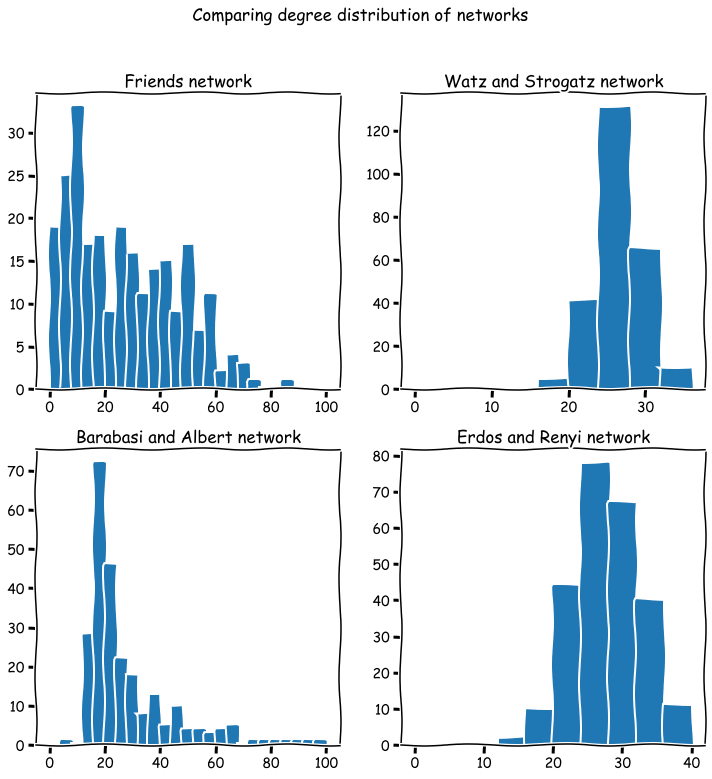

In [308]:
# comparing degree distribution

interval = 4
boundary = 25

def get_degree_distribtuions(g):
    degres = list(g.degree())
    max_degree = max(degres, key=lambda x: x[1])
    
    degres_distribution_Y = np.zeros(max_degree[1] // interval + 1)
    degres_distribution_X = np.arange(0, max_degree[1], interval, dtype=int)
    for degree_info in degres:
        k = degree_info[1] // interval
        degres_distribution_Y[k] += 1
    
    return degres_distribution_X[:boundary], degres_distribution_Y[:boundary]

fig, ax = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Comparing degree distribution of networks')

x, y = get_degree_distribtuions(g)
ax[0, 0].set_title("Friends network")
ax[0, 0].bar(x, y, width=interval, align="edge")

x, y = get_degree_distribtuions(ws_graph)
ax[0, 1].set_title("Watz and Strogatz network")
ax[0, 1].bar(x, y, width=interval, align="edge")

x, y = get_degree_distribtuions(ba_graph)
ax[1, 0].set_title("Barabasi and Albert network")
ax[1, 0].bar(x, y, width=interval, align="edge")

x, y = get_degree_distribtuions(gnm_random_graph)
ax[1, 1].set_title("Erdos and Renyi network")
ax[1, 1].bar(x, y, width=interval, align="edge")

| Param name | Friends network | WS network | ER netrwork | BA network |
| :--- | :---: | :---: | :---: | :---: |
| Size | 3425 | 3276 | 3425 | 3555 |
| Order | 252 | 252 | 252 | 252 |
| Density | 0.108 | 0.104 | 0.108 | 0.112 | 
| Clustering coef | 0.570 | 0.164 | 0.109 | 0.207 |
| Avg path | 2.280 | 1.983 | 1.939 | 1.945 |
| Diameter | 5 | 3 | 3 | 3 |

In [353]:
cliques = list(nx.find_cliques(g))
max_clique_size = nx.graph_clique_number(g)

In [354]:
print('Max clique size: %d' % max_clique_size)

Max clique size: 19


In [365]:
# Check, that all К19 are formed by DIHT students
# Thanks to faculties_dict it was clear that DIHT id = 27176
DIHT_faculty_id = 27176

for clique in cliques:
    if len(clique) == max_clique_size:
        if any(g.nodes[v]["faculty"] == DIHT_faculty_id for v in clique):
            continue
        print('Found clique not from DIHT', clique)

All cliques were formed by DIHT students.

## Step4: Communities

In [411]:
# Community analysis was done with Gephi tool
processed_data = pandas.read_csv("./data/gephi_processed_data.csv")

<BarContainer object of 10 artists>

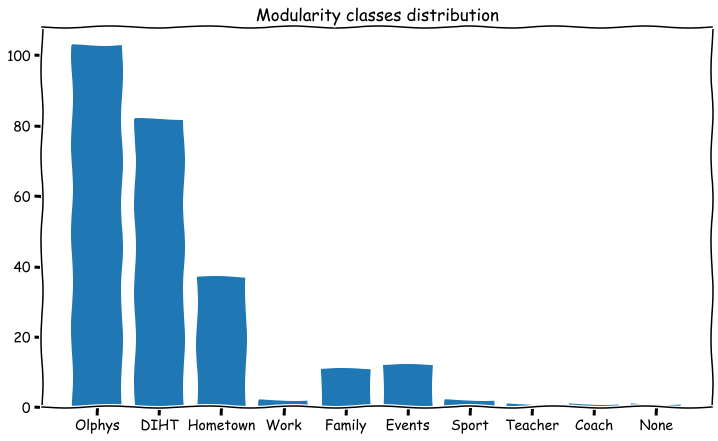

In [433]:
modularity_classes = np.array(processed_data["modularity_class"])
number_of_classes = np.size(np.unique(modularity_classes))
hist, bins = np.histogram(modularity_classes, bins=np.arange(number_of_classes + 1))

x = np.arange(number_of_classes)
y = hist

plt.figure(figsize=(12, 7))
plt.title("Modularity classes distribution")
plt.xticks(x, ["Olphys", "DIHT", "Hometown", "Work", "Family", "Events", "Sport", "Teacher", "Coach", "None"])
plt.bar(x, hist)

For each class print the most 5 popular people (with high vertex degree).

In [424]:
processed_data.sort_values(["modularity_class", "Degree"], ascending=False, inplace=True)
next_data = processed_data.filter(["Label", "modularity_class", "Degree"])
next_data[next_data["modularity_class"] != next_data["modularity_class"].shift(5)]

Label  modularity_class  Degree
249       Marina Eschenko                 9       0
248     Sergey Kovalevsky                 8       0
229        Inna Gaevskaya                 7       0
210      Alexey Kuznetsov                 6       1
211          Oleg Podgalo                 6       1
92   Anastasia Zhiboedova                 5      24
201      Vladislav Dyukov                 5      17
112      Tanya Babushkina                 5      16
104        Vika Zakharova                 5      12
174    Ksyusha Kuprianova                 5      10
194        Irina Sikalova                 4      16
87     Elizaveta Sikalova                 4      11
129        Sergey Sikalov                 4       9
197         Vera Sikalova                 4       9
191     Anastasia Lyagina                 4       8
188   Kristina Grigoryeva                 3       1
189      Darya Reshetneva                 3       1
9           Pavel Mazhnik                 2     159
90          Andrey Golman                 2      46
121              DELETED                  2      30
125       Maxim Plyushkin                 2      20
220         Yulia Dubonos                 2      19
12   Alexander Khalaydzhi                 1      87
68    Talgat Akhmetzyanov                 1      74
70             Oleg Polin                 1      71
145      Malik Gazizullin                 1      69
81           Liza Dakhova                 1      67
3       Dmitry Alexandrov                 0      71
25          Ilya Lukyanov                 0      67
14     Alexandra Sokolova                 0      63
10         Misha Danilyak                 0      62
4             Yan Kimberg                 0      58